<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/FineTuning-group-0.5std_and_mean-70_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
%cd ../

/


In [ ]:
%cd content/

/content


In [2]:
!rm -rf ProjectMLDL

In [ ]:
!ls

sample_data


In [3]:
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 90 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (90/90), done.
/content/ProjectMLDL


In [4]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.trainer import Trainer
from copy import copy

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [6]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified



classe: 90


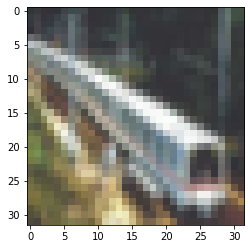

In [7]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

In [8]:
RANDOM_SEED = [42,13,10]
# Settings
DEVICE = 'cuda'

NUM_CLASSES = 100       # Total number of classes

VAL_SIZE = 0.1          # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128        # Batch size
LR = 2               # Initial learning rate
                       
MOMENTUM = 0.9          # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5     # Weight decay from iCaRL

NUM_RUNS = 3            # Number of runs of every method
                        # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70         # Total number of training epochs
MILESTONES = [49, 63]   # Step down policy from iCaRL (MultiStepLR)
                        # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2             # Gamma factor from iCaRL

## Fine Tuning

In [9]:
  train_data.__shuffle_seed__(RANDOM_SEED[0])
  test_data.__shuffle_seed__(RANDOM_SEED[0])
  

  indexes_train_data = train_data.__incremental_indexes__(True)
  indexes_test_data = test_data.__incremental_indexes__(False)

In [10]:
train_dataloader = [[] for i in range(10)]
val_dataloader = [[] for i in range(10)]
test_dataloader = [[] for i in range(10)]
for i in range(10):
  train_dataset = Subset(train_data, indexes_train_data[i])
  train_set, val_set = torch.utils.data.random_split(train_dataset, [int(0.8*len(indexes_train_data[0])), int(0.2*len(indexes_train_data[0]))])
  tmp_dl = DataLoader(train_set, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      drop_last=True)
  train_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi 
  tmp_dl = DataLoader(val_set, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      drop_last=True)
  val_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi


  test_dataset = Subset(test_data, indexes_test_data[i])
  tmp_dl = DataLoader(test_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      drop_last=True)
  test_dataloader[i] = copy(tmp_dl) # classi incrementali: 0:0-9, 1:0-19, 2:0-29, ..., 9:0-99

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
import torch
import torch.nn as nn
from torch.backends import cudnn
from copy import deepcopy

In [12]:
def to_onehot(net, targets, device): 
  '''
  Args:
  targets : dataloader.dataset.targets of the new task images
  '''
  num_classes = net.fc.out_features
  one_hot_targets = torch.eye(num_classes)[targets]

  return one_hot_targets.to(device)

In [13]:
def train(net, criterion, optimizer, train_dl, device):
  net.train()

  running_loss = 0
  # per ogni gruppo di classi in train mi prendo le labels e le immagini
  # azzero i gradienti, mi sposto sulla gpu e faccio onehot delle labels
  # calcolo output, loss, etc.
  # alla fine di tutti i batches aggiorno la epoch_loss
  for batch in train_dl:
    labels = batch[2]
    images = batch[1]
    optimizer.zero_grad()

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    one_hot_labels = to_onehot(net, labels, device) 

    output = net(images)
    loss = criterion(output, one_hot_labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    epoch_loss = running_loss/len(train_dl)
  return epoch_loss
    

In [14]:
#### VALIDATION

def validate(net, criterion, optimizer, validation_dl, device):
  net.train(False)
  running_loss=0
  running_corrects = 0
  total = 0
  # come train(), ma prendo anche le predictions per fare qualche statistica
  for batch in validation_dl:
    labels = batch[2]
    images = batch[1]
    total += labels.size(0)
    optimizer.zero_grad()

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    one_hot_labels = to_onehot(net, labels, device) 

    output = net(images)
    loss = criterion(output, one_hot_labels)
    
    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    running_corrects += torch.sum(preds == labels.data).data.item()
  else:
    val_loss = running_loss/len(validation_dl)
    

  val_accuracy = running_corrects / float(total)
  

  return val_loss, val_accuracy

In [15]:
def test(best_net, test_dl, device):
  """Test the model.
  Returns:
      accuracy (float): accuracy of the model on the test set
  """

  best_net.train(False)  # Set Network to evaluation mode

  running_corrects = 0
  total = 0

  all_preds = torch.tensor([]) # to store all predictions
  all_preds = all_preds.type(torch.LongTensor)
  all_targets = torch.tensor([])
  all_targets = all_targets.type(torch.LongTensor)
  # solito ciclo
  for _, images, labels in test_dl:
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      # Forward Pass
      outputs = best_net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Append batch predictions and labels
      all_targets = torch.cat(
          (all_targets.to(device), labels.to(device)), dim=0
      )
      all_preds = torch.cat(
          (all_preds.to(device), preds.to(device)), dim=0
      )

  # Calculate accuracy
  accuracy = running_corrects / float(total)  


  return accuracy, all_targets, all_preds

In [16]:
def increment_classes(net, n=10):
  """Add n classes in the final fully connected layer."""

  in_features = net.fc.in_features  # size of each input sample
  out_features = net.fc.out_features  # size of each output sample
  weight = net.fc.weight.data

  net.fc = nn.Linear(in_features, out_features+n)
  net.fc.weight.data[:out_features] = weight

In [18]:
net = resnet32()
criterion = nn.BCEWithLogitsLoss()



net.to(DEVICE)
cudnn.benchmark
num_epochs = 70

epoch_losses = [[] for i in range(10)]
for i in range(10):
  net.to(DEVICE)
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)

  best_acc = 0
  best_net = deepcopy(net)

  # ad ogni epoca chiamo il train, salvo le loss e trovo il modello migliore con l'evaluation
  for epoch in range(num_epochs):
    e_loss = train(net, criterion, optimizer, train_dataloader[i], DEVICE)
    epoch_losses[i].append(e_loss)
    print(f"Epoch[{epoch}] loss: {e_loss} LR: {scheduler.get_last_lr()}")
    validate_loss, validate_acc = validate(net, criterion, optimizer, val_dataloader[i], DEVICE)
    print(f"Validation on group[{i}] of 10 classes")
    print(f"val loss: {validate_loss}")
    print(f"val acc: {validate_acc}")
    scheduler.step()
    if validate_acc > best_acc:
      best_acc = validate_acc
      best_net = deepcopy(net)
      best_epoch = epoch
      print("Best model updated")
    print("")

  print(f"Group[{i}]Finished!")
  print(f"Best model at epoch {best_epoch}, best accuracy: {best_acc:.2f}")
  print("")
  acc_all, all_targets, all_preds = test(best_net, test_dataloader[i], DEVICE)
  print(f"Testing classes seen so far, accuracy: {acc_all}")
  print("")
  print("=============================================")
  print("")

  if i < 9:
    increment_classes(net)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0] loss: 0.42441276004237516 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.5755263864994049
val acc: 0.10602678571428571
Best model updated

Epoch[1] loss: 0.32548307314995795 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.3227314182690212
val acc: 0.1015625

Epoch[2] loss: 0.3234295162462419 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.3245418838092259
val acc: 0.10267857142857142

Epoch[3] loss: 0.3228277073752496 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.3220545564379011
val acc: 0.140625
Best model updated

Epoch[4] loss: 0.32228195090447703 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.32126443300928387
val acc: 0.13392857142857142

Epoch[5] loss: 0.32165526190111715 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.32074046560696196
val acc: 0.1328125

Epoch[6] loss: 0.32032644748687744 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.31945409945079256
val acc: 0.15290178571428573
Best model updated



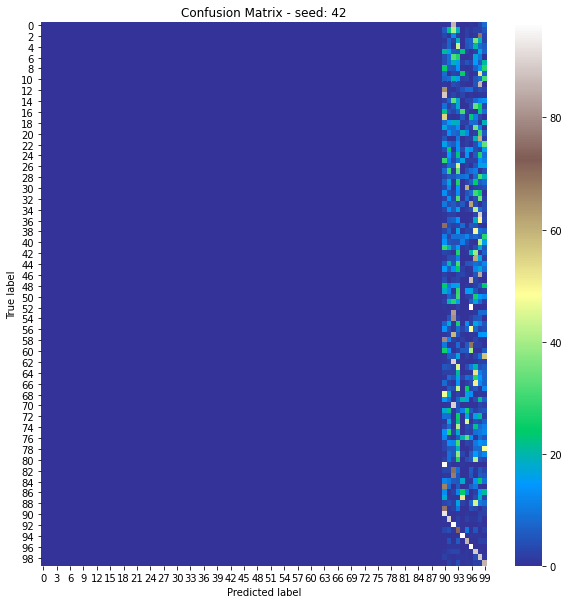

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plotConfusionMatrix(confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix - seed: {}".format(seed))

	#filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	#plt.savefig(filename, format='png', dpi=300)
	plt.show()
 
 
t = all_targets.cpu().data.numpy()
p = all_preds.cpu().data.numpy()
confusionMatrixData = confusion_matrix(t, p)
plotConfusionMatrix(confusionMatrixData, RANDOM_SEED[0])
